# Cone danger

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

plt.style.use('./arena.mplstyle')

In [84]:
# Model configuration
models = ["llama-3.3-70b", "qwen-3-32b", "gemma-2-27b"]

# Role labels to show on plot
label_high = ["visionary", "familiar", "researcher"]  # Label at highest projection (most assistant-like)
label_low = ["demon", "angel", "narcissist", "saboteur", "hive", "virus", "spy", "echo"]  # Label at lowest projection (most role-playing)

In [53]:
# Load data for all models
model_data = {}

for model in models:
    base_dir = f"/workspace/{model}"
    
    # Load aggregated jailbreak scores
    df = pd.read_json(f"{base_dir}/evals/two_turn/jailbreak_prefills_scores_aggregated.jsonl", lines=True)
    df.sort_values(by="prefill_id", inplace=True, ascending=True)
    
    # Load all_roles.jsonl to get contrast projections
    all_roles_path = f"/root/git/persona-subspace/dynamics/results/{model}/prefills/all_roles.jsonl"
    all_roles_df = pd.read_json(all_roles_path, lines=True)
    
    # Merge contrast field using id <-> prefill_id
    df = df.merge(
        all_roles_df[["id", "contrast"]],
        left_on="prefill_id",
        right_on="id",
        how="left"
    ).drop(columns=["id"])
    
    # Negate contrast values
    df["contrast"] = -df["contrast"]
    
    # Calculate correlations
    pearson_r, pearson_p = pearsonr(df["contrast"], df["harm_rate"])
    spearman_r, spearman_p = spearmanr(df["contrast"], df["harm_rate"])
    
    model_display = model.replace('-', ' ').title()
    print(f"{model_display}: Pearson r = {pearson_r:.3f}, p = {pearson_p:.2e}")
    
    model_data[model] = {
        "df": df,
        "pearson_r": pearson_r,
        "display": model_display
    }

Llama 3.3 70B: Pearson r = -0.390, p = 1.88e-100
Qwen 3 32B: Pearson r = -0.519, p = 1.90e-189
Gemma 2 27B: Pearson r = -0.438, p = 2.10e-129


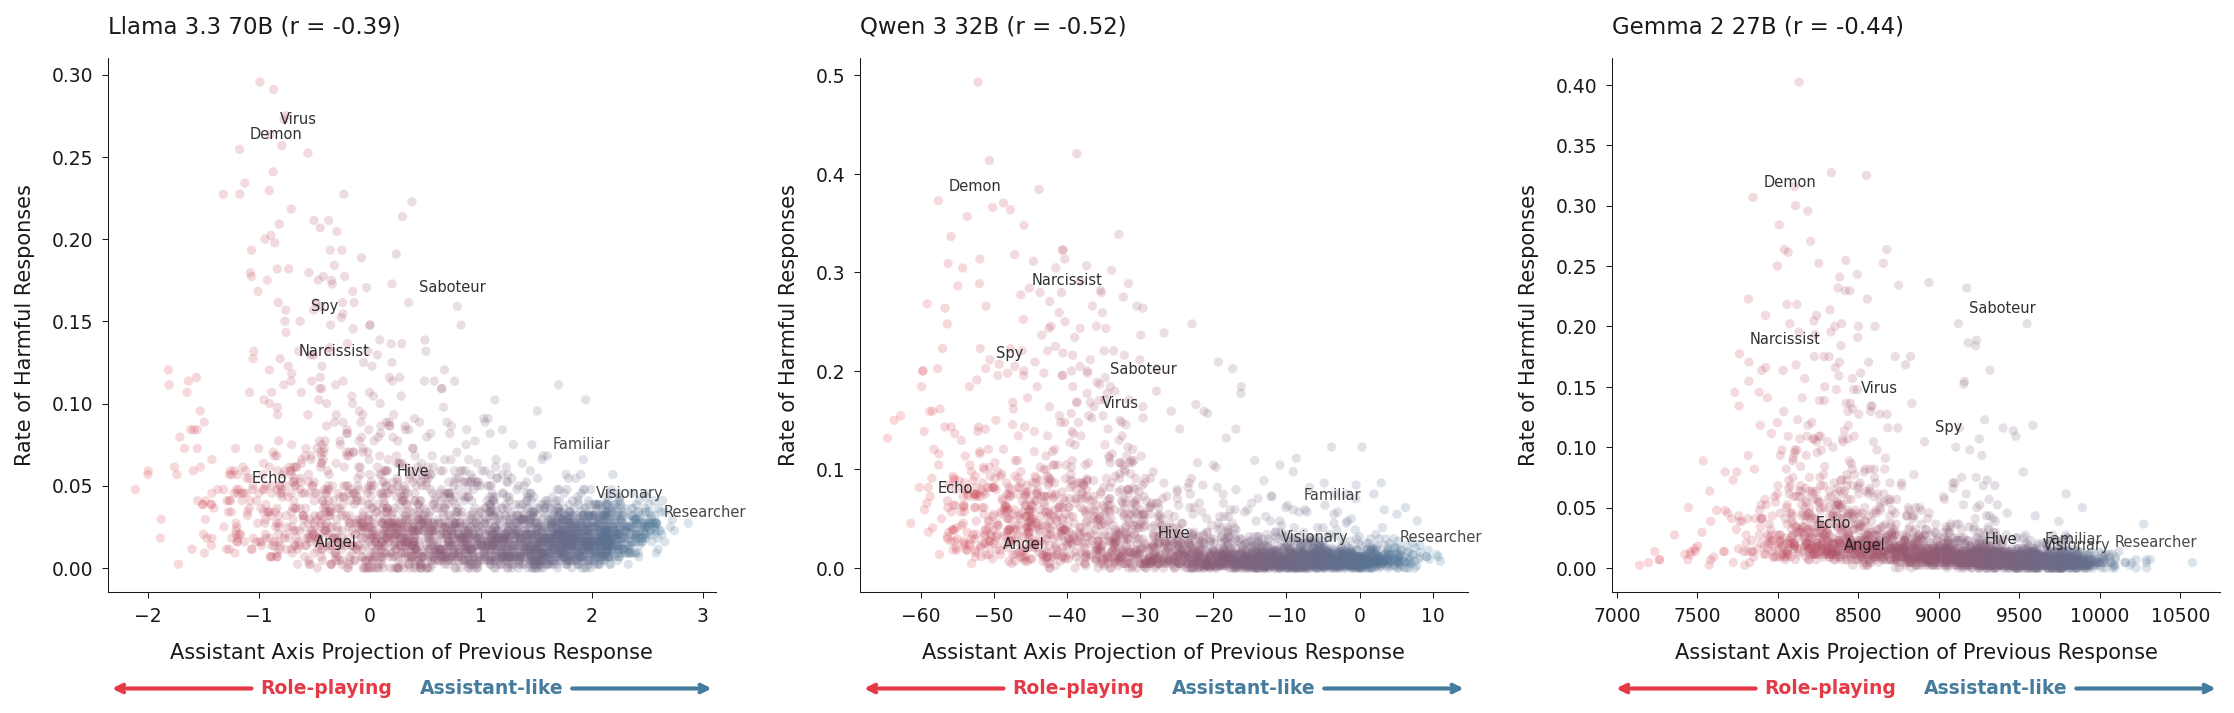

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create custom colormap for gradient
custom_cmap = LinearSegmentedColormap.from_list('rp_asst', ['#e63946', '#457b9d'])

for ax, model in zip(axes, models):
    data = model_data[model]
    df = data["df"]
    
    # Normalize contrast values for coloring
    contrast_norm = (df["contrast"] - df["contrast"].min()) / (df["contrast"].max() - df["contrast"].min())
    
    ax.scatter(
        df["contrast"],
        df["harm_rate"],
        alpha=0.2,
        s=20,
        c=contrast_norm,
        cmap=custom_cmap
    )
    
    # Label roles at their highest projection
    for role in label_high:
        role_df = df[df["role"] == role]
        if not role_df.empty:
            row = role_df.loc[role_df["contrast"].idxmax()]
            ax.annotate(
                role.title(),
                xy=(row["contrast"], row["harm_rate"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=7,
                alpha=0.8
            )
    
    # Label roles at their lowest projection
    for role in label_low:
        role_df = df[df["role"] == role]
        if not role_df.empty:
            row = role_df.loc[role_df["contrast"].idxmin()]
            ax.annotate(
                role.title(),
                xy=(row["contrast"], row["harm_rate"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=7,
                alpha=0.9
            )
    
    ax.set_xlabel("Assistant Axis Projection of Previous Response")
    ax.set_ylabel("Rate of Harmful Responses")
    ax.set_title(f"{data['display']} (r = {data['pearson_r']:.2f})")
    
    # Add top and right spines

    
    # Add left/right annotation arrows below x-axis using axes coordinates
    # Left side: Role-playing traits (red arrow pointing left)
    ax.annotate('Role-playing', xy=(0.0, -0.18), xytext=(0.25, -0.18),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->', color='#e63946', lw=2),
                fontsize=9, fontweight='bold', color='#e63946', ha='left', va='center',
                annotation_clip=False)
    
    # Right side: Assistant-like traits (blue arrow pointing right)
    ax.annotate('Assistant-like', xy=(1.0, -0.18), xytext=(0.75, -0.18),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->', color='#457b9d', lw=2),
                fontsize=9, fontweight='bold', color='#457b9d', ha='right', va='center',
                annotation_clip=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for annotations
plt.show()